In [1]:
import numpy as np
import pandas as pd
import qstock as qs
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import pickle
import quantstats
import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['SimHei']#用来显示中文标签
plt.rcParams['axes.unicode_minus'] = False#用来正常显示负号

In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in Matplo

In [2]:
def saveRegressionResults(filepath,results):
    ''''
    filepath: 保存路径/文件名
    results: 回归结果
    '''
    with open(filepath, 'wb') as f:
        pickle.dump(results, f)

In [3]:
def openRegressionResults(filepath):
    ''''
    filepath: 保存路径/文件名
    results: 回归结果
    '''
    with open(filepath, 'rb') as f:
        load_model = pickle.load(f)
    return load_model

# 获取数据

In [ ]:
# 预先用excel处理过ST、退市和B股和上市不足60天的股票
code = pd.read_excel('TRD_co.xlsx')
stock_name = code.iloc[:,1]
his_data = qs.get_data(stock_name,start='20180101',end='20221231', fqt=2)
his_data['return'] = his_data.groupby('code')['close'].pct_change()
his_data['date'] = his_data.index
his_data = his_data.dropna()

# risk free return
rf = qs.ib_rate()
rf['报告日'] = pd.to_datetime(rf['报告日'])
rf=rf.loc[rf['报告日']>'2018-01-01']
rf = rf.set_index('报告日')
rf

In [5]:
# 三因子数据
factors = pd.read_excel('STK_MKT_THRFACDAY.xlsx')
factors['TradingDate'] = pd.to_datetime(factors['TradingDate'])
factors = factors.set_index('TradingDate')
factors

,RiskPremium1,SMB1,HML1
TradingDate,,,
2018-01-02,0.013264,-0.003363,0.005018
2018-01-03,0.005993,0.001940,-0.005753
2018-01-04,0.004030,-0.004029,-0.002465
2018-01-05,0.001945,0.000196,0.003868
2018-01-08,0.003841,-0.003801,0.003753
...,...,...,...
2022-12-26,0.007776,0.011487,-0.012163
2022-12-27,0.009958,-0.007401,0.002709
2022-12-28,-0.004848,-0.008969,0.007287


In [ ]:
processData = his_data.merge(factors,left_on='date', right_on='TradingDate',how='inner')

In [ ]:
processData.to_csv('processData.csv',encoding = 'utf_8_sig')

# 传统特质波动率因子的计算

## FF回归

HCO：怀特异方差稳健标准误

由于A股市场当中每一个样本都具有个体固定效应和截面异方差问题，因此需要选用异方差稳健标准误来缓解异方差问题

Fama-MacBeth Regression是一种两步截面回归检验方法，排除了残差在截面上的相关性对标准误的影响

In [4]:
processData = pd.read_csv('processData.csv')
processData = processData.drop(columns='Unnamed: 0',axis=1)
stock_code = list(set(processData.code))
processData['date'] = pd.to_datetime(processData['date'])
processData['year'] = processData['date'].dt.year
processData = processData.set_index('date')
processData.drop(index=datetime.datetime(2018,1,2),axis=0,inplace=True)
processData

,name,code,open,high,low,close,volume,turnover,turnover_rate,return,TradingDate,RiskPremium1,SMB1,HML1,year
date,,,,,,,,,,,,,,,
2018-01-03,申华控股,600653,34162.08,34511.35,33812.80,34511.35,58231,15820442.0,0.33,0.010224,2018-01-03,0.005993,0.001940,-0.005753,2018
2018-01-03,汇通能源,600605,313.82,317.18,313.58,316.94,3779,5146011.0,0.26,0.006095,2018-01-03,0.005993,0.001940,-0.005753,2018
2018-01-03,深康佳Ａ,16,109.62,111.42,109.62,111.24,153677,95236414.0,0.96,0.016447,2018-01-03,0.005993,0.001940,-0.005753,2018
2018-01-03,云赛智联,600602,3381.94,3482.76,3377.14,3429.95,69470,50023064.0,0.79,0.005629,2018-01-03,0.005993,0.001940,-0.005753,2018
2018-01-03,中国宝安,9,58.89,59.85,58.73,59.69,230921,170636550.0,1.09,0.013585,2018-01-03,0.005993,0.001940,-0.005753,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-01,同仁堂,600085,383.60,384.72,359.08,370.36,182004,704779120.0,1.33,-0.043591,2018-06-01,-0.007854,-0.000625,0.007961,2018
2018-06-01,明星电力,600101,43.28,43.78,42.92,43.21,17238,13147503.0,0.53,-0.008263,2018-06-01,-0.007854,-0.000625,0.007961,2018
2018-06-01,新芝生物,430685,10.83,12.05,10.83,12.05,120,39530.0,0.03,0.124067,2018-06-01,-0.007854,-0.000625,0.007961,2018


In [ ]:
%%time
stock_code = list(set(processData.code))
x = factors
x = sm.add_constant(x)
exog = ['const','RiskPremium1','SMB1','HML1']
results = {}
window = 20
for stock in stock_code:
    y = processData.loc[processData.code==stock]
    y.drop_duplicates('TradingDate',inplace=True)
    y = y['return']
    y = pd.concat([y,0.01*rf['1月']],axis=1,join='inner')
    y = pd.DataFrame(y['return'] - y['1月'],columns=['ex_ret'])
    panel = pd.concat([x,y],axis=1,join = 'inner')
    panel = panel.dropna(axis=0)
    result = RollingOLS(panel['ex_ret'],panel[exog],window = window).fit(cov_type='HC0')
    results[stock] = result

In [ ]:
%%time
# 稳健性检验：将收益率变为t+1期(以下一期收益率作为本期预期收益率进行预测)
stock_code = list(set(processData.code))
x = factors
x = sm.add_constant(x)
exog = ['const','RiskPremium1','SMB1','HML1']
results = {}
window = 20
for stock in stock_code:
    y = processData.loc[processData.code==stock]
    y.drop_duplicates('TradingDate',inplace=True)
    y = y['return'].shift(-1)
    y = pd.concat([y,0.01*rf['1月']],axis=1,join='inner')
    y = pd.DataFrame(y['return'] - y['1月'],columns=['ex_ret'])
    panel = pd.concat([x,y],axis=1,join = 'inner')
    panel = panel.dropna(axis=0)
    result = RollingOLS(panel['ex_ret'],panel[exog],window = window).fit(cov_type='HC0')
    results[stock] = result
    
mean_ID_Vol_dict = {} 
ID_Vol_TS_dict = {}
for key in stock_code:
    ID_Vol_TS_dict[key] = (np.sqrt(results[key].mse_resid))
    mean_ID_Vol_dict[key] = (np.sqrt(results[key].mse_resid.mean()))
    
ID_Vol_list = pd.DataFrame(mean_ID_Vol_dict.values(),index=stock_code) #把index设为stock code方便识别选股
ID_Vol_list['code'] = stock_code
ID_Vol_list['group'] = pd.qcut(ID_Vol_list.iloc[:,0],5,labels=[1,2,3,4,5])

# 将特质波动率分组对应到股票上
group1 = ID_Vol_list.loc[ID_Vol_list['group']==1].code
group2 = ID_Vol_list.loc[ID_Vol_list['group']==2].code
group3 = ID_Vol_list.loc[ID_Vol_list['group']==3].code
group4 = ID_Vol_list.loc[ID_Vol_list['group']==4].code
group5 = ID_Vol_list.loc[ID_Vol_list['group']==5].code

DataGroup1 = processData.loc[processData.code.isin(group1) ]
DataGroup2 = processData.loc[processData.code.isin(group2) ]
DataGroup3 = processData.loc[processData.code.isin(group3) ]
DataGroup4 = processData.loc[processData.code.isin(group4) ]
DataGroup5 = processData.loc[processData.code.isin(group5) ]

# 净值
nv_group1 = (1+DataGroup1.groupby('date')['return'].mean()).cumprod()
nv_group2 = (1+DataGroup2.groupby('date')['return'].mean()).cumprod()
nv_group3 = (1+DataGroup3.groupby('date')['return'].mean()).cumprod()
nv_group4 = (1+DataGroup4.groupby('date')['return'].mean()).cumprod()
nv_group5 = (1+DataGroup5.groupby('date')['return'].mean()).cumprod()
net_value_panel = pd.DataFrame(data = {'Group1':nv_group1,'Group2':nv_group2,'Group3':nv_group3,'Group4':nv_group4,'Group5':nv_group5})
net_value_panel.plot(title='net value',figsize=(20,6))

对于误差项来说，均方误=方差。因为MSE(x_bar) = Var(x_bar) + [E(x_bar) - x]，即估计量无偏时均方误等于方差

### 保存回归结果（这种方法很常用）

In [ ]:
filepath = r'ID_vol/classicIDvolRegression.pkl'
saveRegressionResults(filepath,results)

In [25]:
filepath = r'ID_vol/classicIDvolRegression.pkl'
load_model = openRegressionResults(filepath)
load_model

{688128: <statsmodels.regression.rolling.RollingRegressionResults at 0x2019614f308>,
 1: <statsmodels.regression.rolling.RollingRegressionResults at 0x20309bc7e08>,
 2: <statsmodels.regression.rolling.RollingRegressionResults at 0x20327ca4c48>,
 600815: <statsmodels.regression.rolling.RollingRegressionResults at 0x202feba1b08>,
 688129: <statsmodels.regression.rolling.RollingRegressionResults at 0x202eeb7e4c8>,
 688133: <statsmodels.regression.rolling.RollingRegressionResults at 0x2030ebcba08>,
 6: <statsmodels.regression.rolling.RollingRegressionResults at 0x203390bd108>,
 7: <statsmodels.regression.rolling.RollingRegressionResults at 0x20184af24c8>,
 8: <statsmodels.regression.rolling.RollingRegressionResults at 0x201848abfc8>,
 9: <statsmodels.regression.rolling.RollingRegressionResults at 0x2018518c148>,
 10: <statsmodels.regression.rolling.RollingRegressionResults at 0x2028a490d48>,
 11: <statsmodels.regression.rolling.RollingRegressionResults at 0x201848fbe08>,
 12: <statsmodels.

In [26]:
mean_ID_Vol_dict = {} 
ID_Vol_TS_dict = {}
stock_code = load_model.keys()
for key in load_model.keys():
    ID_Vol_TS_dict[key] = (np.sqrt(load_model[key].mse_resid))
    mean_ID_Vol_dict[key] = (np.sqrt(load_model[key].mse_resid.mean()))

相比for i in range(len(list))的按照索引循环读取元素来说，直接for 元素 in list更快（省掉了检索索引的步骤

或者用enumerate同时兼顾索引和元素：

for i, result in enumerate(example_list):

    print(i)
    
    print(result)

## 对传统特质波动率因子进行回测

### 按照特质波动率因子大小用排序法分成五组 (分组方法要注意，很常用）

排序法用qcut不用cut：保证每一组变量个数尽量相同。

In [27]:
ID_Vol_list = pd.DataFrame(mean_ID_Vol_dict.values(),index=stock_code) #把index设为stock code方便识别选股
ID_Vol_list['code'] = stock_code
ID_Vol_list['group'] = pd.qcut(ID_Vol_list.iloc[:,0],5,labels=[1,2,3,4,5])
ID_Vol_list

,0,code,group
688128,0.027451,688128,4
1,0.013567,1,1
2,0.013160,2,1
600815,0.018663,600815,1
688129,0.017938,688129,1
...,...,...,...
688122,0.028411,688122,4
688123,0.033728,688123,5
688125,0.032205,688125,5
688126,0.032997,688126,5


In [28]:
# 每一组的ID_Vol描述性统计
ID_Vol_list.groupby('group').describe()

0                                                              \
       count      mean       std       min       25%       50%       75%   
group                                                                      
1      978.0  0.015538  0.003152  0.003225  0.013765  0.016393  0.018082   
2      977.0  0.021263  0.001069  0.019306  0.020357  0.021311  0.022152   
3      977.0  0.024699  0.000914  0.023077  0.023920  0.024703  0.025522   
4      977.0  0.028198  0.001172  0.026316  0.027178  0.028145  0.029197   
5      978.0  0.044530  0.069036  0.030423  0.032223  0.034392  0.038982   

                  code                                                 \
            max  count           mean            std   min        25%   
group                                                                   
1      0.019304  978.0  390772.054192  281001.614938   1.0    2468.25   
2      0.023072  977.0  334379.633572  277817.384973  11.0    2468.00   
3      0.026316  977.0  323344.812692  263082.355010  10.0    2683.00   
4      0.030415  977.0  320022.601842  255919.728972   9.0    2895.00   
5      1.355458  978.0  436893.119632  267483.187461   7.0  300586.50   

                                      
            50%        75%       max  
group                                 
1      600311.0  601184.25  833819.0  
2      300964.0  601377.00  688981.0  
3      300602.0  601231.00  835184.0  
4      300610.0  601456.00  839729.0  
5      301223.5  688193.50  873527.0

<AxesSubplot:title={'center':'net value'}, xlabel='date'>

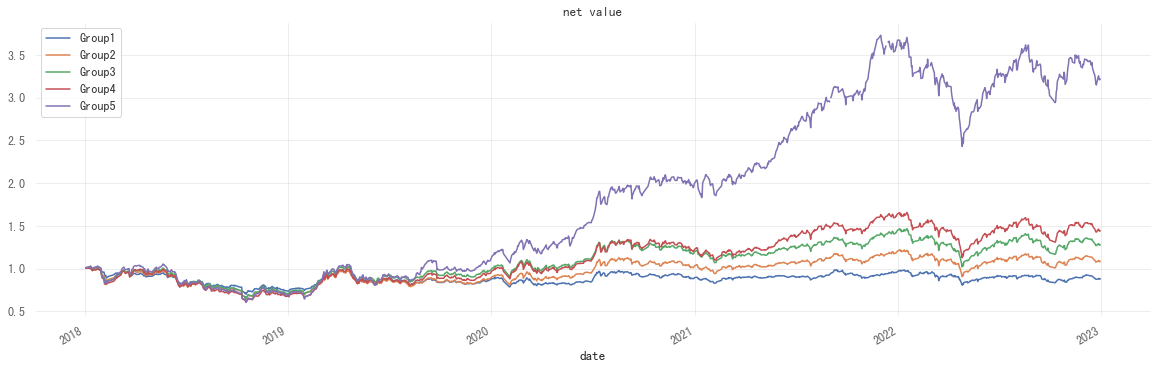

In [33]:
# 将特质波动率分组对应到股票上，直接这样用整个区间的平均特质波动率分组是错误的，引入了未来信息。但是机能限制只是做演示
group1 = ID_Vol_list.loc[ID_Vol_list['group']==1].code
group2 = ID_Vol_list.loc[ID_Vol_list['group']==2].code
group3 = ID_Vol_list.loc[ID_Vol_list['group']==3].code
group4 = ID_Vol_list.loc[ID_Vol_list['group']==4].code
group5 = ID_Vol_list.loc[ID_Vol_list['group']==5].code

DataGroup1 = processData.loc[processData.code.isin(group1) ]
DataGroup2 = processData.loc[processData.code.isin(group2) ]
DataGroup3 = processData.loc[processData.code.isin(group3) ]
DataGroup4 = processData.loc[processData.code.isin(group4) ]
DataGroup5 = processData.loc[processData.code.isin(group5) ]

# 净值
nv_group1 = (1+DataGroup1.groupby('date')['return'].mean()).cumprod()
nv_group2 = (1+DataGroup2.groupby('date')['return'].mean()).cumprod()
nv_group3 = (1+DataGroup3.groupby('date')['return'].mean()).cumprod()
nv_group4 = (1+DataGroup4.groupby('date')['return'].mean()).cumprod()
nv_group5 = (1+DataGroup5.groupby('date')['return'].mean()).cumprod()
net_value_panel = pd.DataFrame(data = {'Group1':nv_group1,'Group2':nv_group2,'Group3':nv_group3,'Group4':nv_group4,'Group5':nv_group5})
net_value_panel.plot(title='net value',figsize=(20,6))

一个list中存了很多个值，我们需要提取出在这个列表中出现的值的所有行的方法：

（比如用股票代码list找到procesData当中对应股票的数据）

processData.code.isin(stock_code)比df[[x == list for x in processData.code]]快很多

每个组的年化收益率计算方法：grouby（stock_code）.pct_change(len(Tseries))计算每个股票的年化收益率，然后将组里所有年化收益率平均即可

分组方法：等权构造组合进行回测

In [34]:
AnnualReturn_Group1 = pd.DataFrame((DataGroup1.groupby(['year','code'])['return'].mean())*250).groupby('year').mean()
AnnualReturn_Group2 = pd.DataFrame((DataGroup2.groupby(['year','code'])['return'].mean())*250).groupby('year').mean()
AnnualReturn_Group3 = pd.DataFrame((DataGroup3.groupby(['year','code'])['return'].mean())*250).groupby('year').mean()
AnnualReturn_Group4 = pd.DataFrame((DataGroup4.groupby(['year','code'])['return'].mean())*250).groupby('year').mean()
AnnualReturn_Group5 = pd.DataFrame((DataGroup5.groupby(['year','code'])['return'].mean())*250).groupby('year').mean()

print('low组:',AnnualReturn_Group1)
print('high组:',AnnualReturn_Group5)
print('high - low多空组合:',AnnualReturn_Group5 - AnnualReturn_Group1)

low组:         return
year          
2018 -0.292698
2019  0.186272
2020 -0.033934
2021  0.051917
2022 -0.089387
high组:         return
year          
2018  1.628507
2019  3.192821
2020  1.820386
2021  1.114153
2022 -0.075157
high - low多空组合:         return
year          
2018  1.921205
2019  3.006550
2020  1.854320
2021  1.062236
2022  0.014230


根据净值图我们可以看到,波动率最高的组合收益远高于其他组合,说明传统特质波动率因子在回测区间内表现不佳,这个异象可能已经消失

### 回测

In [35]:
# 计算多空组合日度收益
Group5_PortRet = DataGroup5.groupby('TradingDate')[['return','year']].mean()
Group1_PortRet = DataGroup1.groupby('TradingDate')[['return','year']].mean()
high_low = Group5_PortRet - Group1_PortRet
high_low['year'] = Group1_PortRet['year']
high_low = high_low.reset_index()
high_low['TradingDate'] = pd.to_datetime(high_low['TradingDate'])
high_low = high_low.set_index(high_low['TradingDate'])

# 年化波动
annual_vol_dict = {}
for year in range(2018,2023):
    annual_vol = quantstats.stats.volatility(high_low.loc[high_low.year==year]['return'],periods=250)
    annual_vol_dict[year]=annual_vol
    print(str(year),':',annual_vol)
    
# 最大回撤
max_dd_dict = {}
for year in range(2018,2023):
    max_dd = quantstats.stats.max_drawdown((1 + high_low.loc[high_low.year==year]['return']).cumprod())
    max_dd_dict[year]=max_dd
    print(str(year),':',max_dd)
    
# 信息比率
ir_dict = {}
for year in range(2018,2023):
    ir = quantstats.stats.information_ratio(high_low.loc[high_low.year==year]['return'],factors.loc[factors.index.year==year]['RiskPremium1'])
    ir_dict[year]=ir
    print(str(year),':',ir)
    
    
# 月度胜率
win_dict = {}
for year in range(2018,2023):
    win = quantstats.stats.win_rate(high_low.loc[high_low.year==year]['return'])
    win_dict[year]=win
    print(str(year),':',win)

2018 : 0.14572634216421715
2019 : 0.169137056406332
2020 : 0.16405540908413893
2021 : 0.1670900042059998
2022 : 0.1679991071296602
2018 : -0.2165271477794981
2019 : -0.09974487536506382
2020 : -0.06344103294455761
2021 : -1.0
2022 : -1.0
2018 : 0.0774240437154787
2019 : 0.0219623626513746
2020 : 0.1151547105029535
2021 : 0.16268128716856653
2022 : 0.03868556256134802
2018 : 0.5289256198347108
2019 : 0.6270491803278688
2020 : 0.6090534979423868
2021 : 0.5983263598326359
2022 : 0.5062240663900415


## 对换手率正交后的特质波动率因子

### 构造因子
- 将传统特质波动率因子对20日换手率回归，取残差作为正交后的特质波动率因子


In [ ]:
# 换手率
turnover20d = pd.DataFrame(data={'turnover20d':processData['turnover_rate'].rolling(20).mean(),'name':processData.name,'code':processData.code})

# 正交化IDVOL和换手率
stock_code = load_model.keys()
exog = ['const','turnover20d']
results = {}
for i,stock in enumerate(stock_code):
    y = pd.DataFrame(ID_Vol_TS_dict[stock],columns=['ID_vol'])
    y = y.loc[~y.index.duplicated(keep='first')]
    x = turnover20d.loc[turnover20d.code==stock]['turnover20d']
    x = x.loc[~x.index.duplicated(keep='first')]
    x = sm.add_constant(x)
    x.drop_duplicates(inplace=True)

    panel = pd.concat([x,y],axis=1,join = 'inner')
    panel = panel.dropna(axis=0)
    panel.drop_duplicates(inplace=True)
    result = sm.OLS(panel['ID_vol'],panel[exog]).fit(cov_type='HC0')
    results[stock] = result

In [ ]:
filepath = r'ID_vol/deTurn20IDvolRegression.pkl'
saveRegressionResults(filepath,results)

In [19]:
filepath = r'ID_vol/deTurn20IDvolRegression.pkl'
load_model_1 = openRegressionResults(filepath)
load_model_1

{688128: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2019614b688>,
 1: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2033d1814c8>,
 2: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x20313bfc808>,
 600815: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x20196110a48>,
 688129: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x20185161a08>,
 688133: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2032dda87c8>,
 6: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x20196118288>,
 7: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2033d1b5208>,
 8: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x202f0b58dc8>,
 9: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2033d189f08>,
 10: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x20331eda888>,
 11: <statsmodels.regression.linear_model.Re

In [20]:
mean_ID_Vol_deTurn20_dict = {} 
ID_Vol_deTurn20_TS_dict = {}
stock_code = load_model_1.keys()
for key in load_model_1.keys():
    ID_Vol_deTurn20_TS_dict[key] = (load_model_1[key].resid)
    mean_ID_Vol_deTurn20_dict[key] = (load_model_1[key].resid.mean())

### 将正交后的特质波动率因子进行分组回测

最大回撤: -1.0
月度胜率: 0.4987593052109181
信息比率: -0.007476650773318559
年化波动: 0.04260751116407612


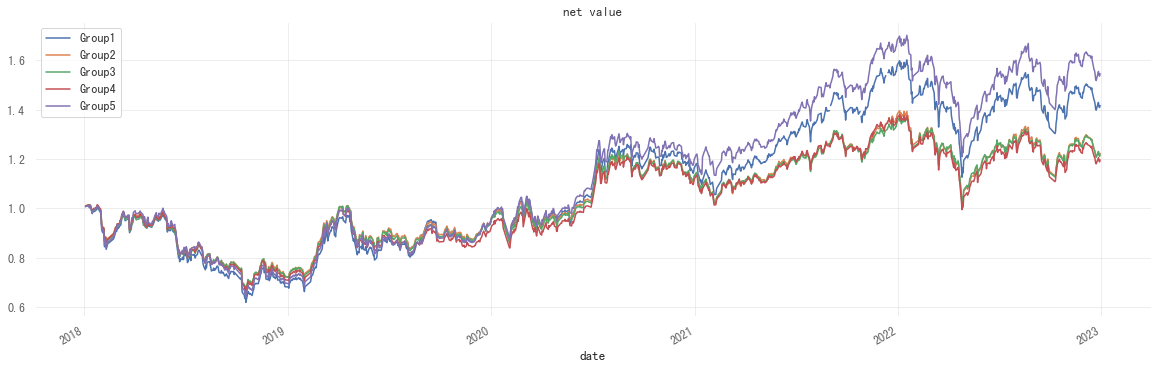

In [21]:
# 排序
ID_Vol_list = pd.DataFrame(mean_ID_Vol_deTurn20_dict.values(),index=load_model_1.keys()) #把index设为stock code方便识别选股
ID_Vol_list['code'] = stock_code
ID_Vol_list['group'] = pd.qcut(ID_Vol_list.iloc[:,0],5,labels=[1,2,3,4,5])

# 将特质波动率分组对应到股票上
group1 = ID_Vol_list.loc[ID_Vol_list['group']==1].code
group2 = ID_Vol_list.loc[ID_Vol_list['group']==2].code
group3 = ID_Vol_list.loc[ID_Vol_list['group']==3].code
group4 = ID_Vol_list.loc[ID_Vol_list['group']==4].code
group5 = ID_Vol_list.loc[ID_Vol_list['group']==5].code

DataGroup1 = processData.loc[processData.code.isin(group1) ]
DataGroup2 = processData.loc[processData.code.isin(group2) ]
DataGroup3 = processData.loc[processData.code.isin(group3) ]
DataGroup4 = processData.loc[processData.code.isin(group4) ]
DataGroup5 = processData.loc[processData.code.isin(group5) ]


# 净值回测
nv_group1 = (1+DataGroup1.groupby('date')['return'].mean()).cumprod()
nv_group2 = (1+DataGroup2.groupby('date')['return'].mean()).cumprod()
nv_group3 = (1+DataGroup3.groupby('date')['return'].mean()).cumprod()
nv_group4 = (1+DataGroup4.groupby('date')['return'].mean()).cumprod()
nv_group5 = (1+DataGroup5.groupby('date')['return'].mean()).cumprod()
net_value_panel = pd.DataFrame(data = {'Group1':nv_group1,'Group2':nv_group2,'Group3':nv_group3,'Group4':nv_group4,'Group5':nv_group5})
net_value_panel.plot(title='net value',figsize=(20,6))

# 因子评价
# 计算多空组合日度收益
Group5_PortRet = DataGroup5.groupby('TradingDate')[['return','year']].mean()
Group1_PortRet = DataGroup1.groupby('TradingDate')[['return','year']].mean()
high_low = Group5_PortRet - Group1_PortRet
high_low['year'] = Group1_PortRet['year']
high_low = high_low.reset_index()
high_low['TradingDate'] = pd.to_datetime(high_low['TradingDate'])
high_low = high_low.set_index(high_low['TradingDate'])

# 最大回撤
max_dd = quantstats.stats.max_drawdown((1 + high_low['return']).cumprod())
print('最大回撤:',max_dd)

# 月度胜率
win = quantstats.stats.win_rate(high_low['return'])
print('月度胜率:',win)


# 信息比率
ir = quantstats.stats.information_ratio(high_low['return'],factors['RiskPremium1'])
print('信息比率:',ir)


# 年化波动
annual_vol = quantstats.stats.volatility(high_low['return'],periods=250)
print('年化波动:',annual_vol)


与换手率正交后,特质波动率高的组合的收益率显著高于其他组,说明特质波动率异象被消除,几乎不存在套利空间

2022年时每一组都出现巨大回撤,这是回撤-1的来源

## 纯真特质波动因子

若因子具有较强的跨期截面相关性，则会导致我们在t 时刻选股时，虽然表面上只参考
了t-1 时刻的因子值，却不可避免地连带使用了t-2 时刻、t-3 时刻、甚至t-4 时刻的因子
信息，而这些早期的因子值，无疑被多次重复使用了。这就意味着我们每一期获得的因
子信息，其实都不够纯净

- 计算经典特质波动率因子和正交特质波动率因子的自相关系数(pcf)
- 暂取滞后阶数N=6，每月月底将本月因子值对过去6个月的因子值做多元线性回归(或者根据pcf来选择滞后阶数)
- 取残差向量𝜇𝑖,𝑡，即为该月所有股票剔除截面相关性之后的波动率因子值，记为纯真波动率因子ID_Vol_deCorr。

Wall time: 18min 16s
Parser   : 236 ms


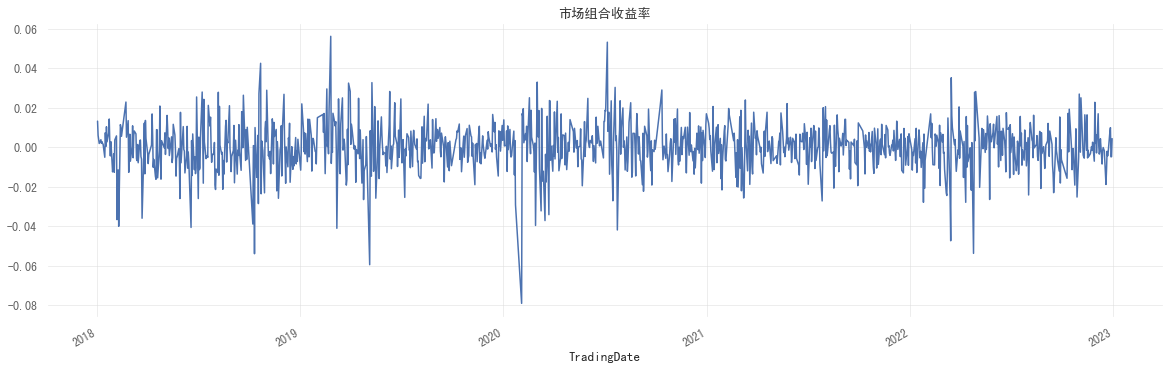

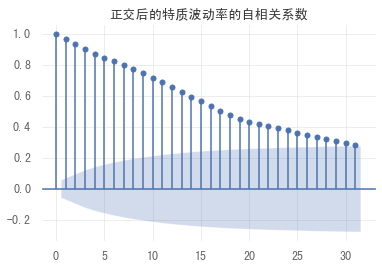

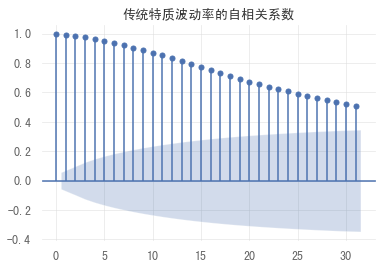

In [30]:
%%time
from statsmodels.graphics.tsaplots import plot_acf  #自相关图
factors['RiskPremium1'].plot(title='市场组合收益率',figsize=(20,6))

ID_Vol_deTurn20_panel = pd.DataFrame()
ID_Vol_TS_panel = pd.DataFrame()
for key in load_model_1.keys():
    df0= pd.DataFrame(ID_Vol_deTurn20_TS_dict[key],columns=[key])
    ID_Vol_deTurn20_panel = pd.concat([ID_Vol_deTurn20_panel,df0],axis=1)
    
for key in load_model.keys():
    df1= pd.DataFrame(ID_Vol_TS_dict[key],columns=[key])
    ID_Vol_TS_panel = pd.concat([ID_Vol_TS_panel,df1],axis=1)    

mkt_ID_Vol_deTurn20 = ID_Vol_deTurn20_panel.mean(axis=1)
mkt_ID_Vol = ID_Vol_TS_panel.mean(axis=1)

plot_acf(mkt_ID_Vol_deTurn20.dropna(),title='正交后的特质波动率的自相关系数').show()
plot_acf(mkt_ID_Vol.dropna(),title='传统特质波动率的自相关系数').show()

<AxesSubplot:title={'center':'mkt_ID_Vol'}>

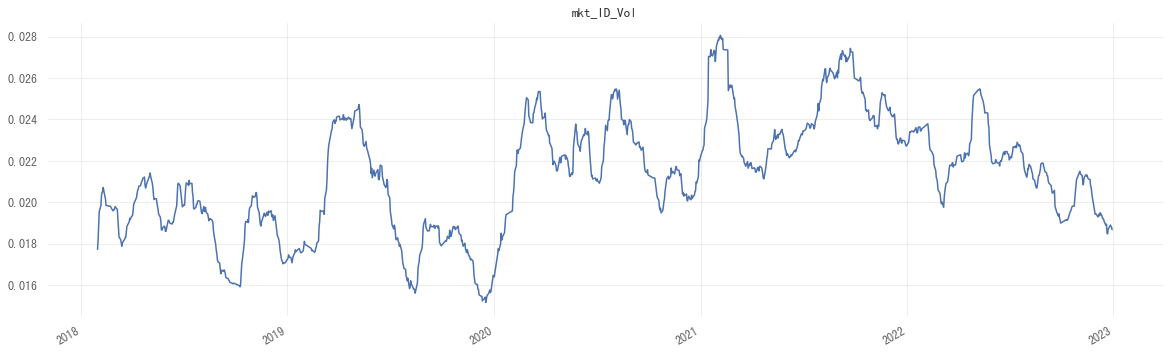

In [31]:
mkt_ID_Vol.plot(title='mkt_ID_Vol',figsize=(20,6))

<AxesSubplot:title={'center':'mkt_ID_Vol_deTurn20'}>

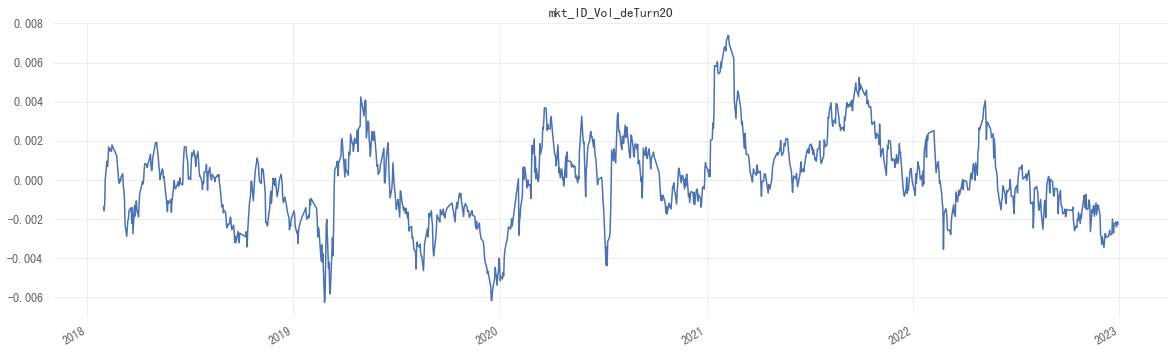

In [32]:
mkt_ID_Vol_deTurn20.plot(title='mkt_ID_Vol_deTurn20',figsize=(20,6))

- 观察市场组合收益率图,我们可以发现市场组合收益率存在波动率集聚现象,说明特质波动率可能存在自相关的情况
- 观察自相关图，传统特质波动率的自相关系数明显高于与换手率正交过后的特质波动率的自相关系数，说明正交换手率可以缓解特质波动率因子的自相关情况
- 观察等权的全市场组合的特质波动率时序图我们也可以发现，传统特质波动率的自相关系数和阶数很高（原因应该在于传统特质波动率不平稳，趋势性很强）
- 观察自相关图我们可以发现，无论是正交后的特质波动率还是传统的特质波动率，时间序列均不平稳。按照原文的滞后6阶自回归取残差得到纯真特质波动率因子是不够科学的，因为特质波动率因子的自相关阶数非常高。
- 下一阶段的研究将着力于用什么模型刻画这个高阶自相关的序列

- 目前只能暂时采用30阶自回归取残差的方法构造纯真波动率因子

In [8]:
%%time
pure_reg_results = {}
for key in load_model_1.keys():
    data = pd.DataFrame(ID_Vol_deTurn20_TS_dict[key],columns=[key]).dropna()
    #剔除上市不足一个季度的股票（防止小样本偏差和时间序列长度不足的问题）
    if len(data)<=60:
        continue
    for l in range(1,31):
        data['vol_lag'+str(l)] = data.iloc[:,0].shift(l)

    exog = ['const']
    for exog_name in data.columns[1:]:
        exog.append(exog_name)

    panel = sm.add_constant(data).dropna()
    res = sm.OLS(panel.iloc[:,1],panel[exog]).fit(cov_type='HC0')
    pure_reg_results[key] = res


Wall time: 2min 42s


In [9]:
filepath = r'ID_vol/PureRegression.pkl'
saveRegressionResults(filepath,pure_reg_results)

In [10]:
filepath = r'ID_vol/PureRegression.pkl'
load_model_2 = openRegressionResults(filepath)
load_model_2

{688128: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x20196027788>,
 1: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x20196298108>,
 2: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2018506ec48>,
 600815: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x201850700c8>,
 688129: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2028a2a6048>,
 688133: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2028a2a6d88>,
 6: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2028a305948>,
 7: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2028a32c7c8>,
 8: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x201850ba088>,
 9: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x201464e2588>,
 10: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x202f5b86708>,
 11: <statsmodels.regression.linear_model.Re

In [11]:
mean_ID_Vol_deCorr_dict = {} 
ID_Vol_deCorr_TS_dict = {}
stock_code = load_model_2.keys()
for key in load_model_2.keys():
    ID_Vol_deCorr_TS_dict[key] = ((load_model_2[key].resid))
    mean_ID_Vol_deCorr_dict[key] = ((load_model_2[key].resid.mean()))

In [12]:
ID_Vol_deCorr_TS_dict[key]

2020-12-08   -0.001066
2020-12-09    0.002087
2020-12-10   -0.000227
2020-12-11   -0.003947
2020-12-14    0.001230
                ...   
2022-12-26   -0.000884
2022-12-27   -0.000960
2022-12-28   -0.000531
2022-12-29   -0.002898
2022-12-30   -0.000405
Length: 502, dtype: float64

最大回撤: -1.0
月度胜率: 0.48966087675765096
信息比率: -0.016805201096823274
年化波动: 0.043632718813333755


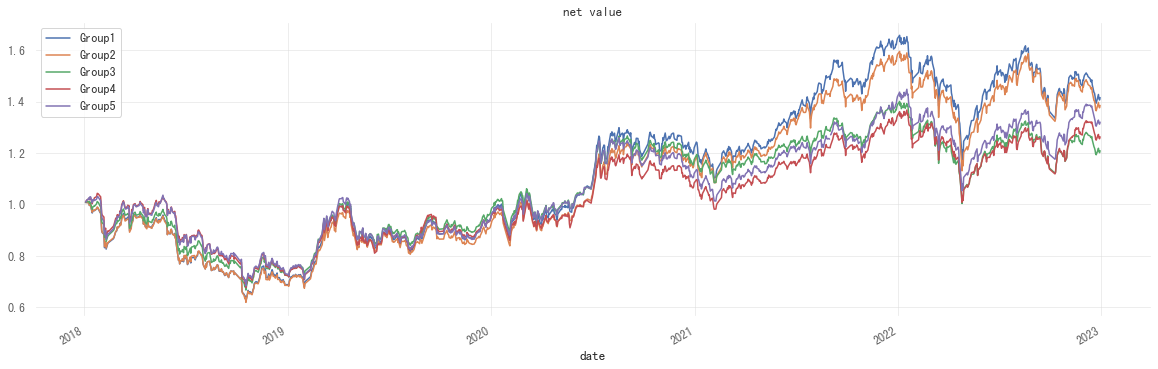

In [13]:
# 排序
ID_Vol_list = pd.DataFrame(mean_ID_Vol_deCorr_dict.values(),index=stock_code) #把index设为stock code方便识别选股
ID_Vol_list['code'] = stock_code
ID_Vol_list['group'] = pd.qcut(ID_Vol_list.iloc[:,0],5,labels=[1,2,3,4,5])

# 将特质波动率分组对应到股票上
group1 = ID_Vol_list.loc[ID_Vol_list['group']==1].code
group2 = ID_Vol_list.loc[ID_Vol_list['group']==2].code
group3 = ID_Vol_list.loc[ID_Vol_list['group']==3].code
group4 = ID_Vol_list.loc[ID_Vol_list['group']==4].code
group5 = ID_Vol_list.loc[ID_Vol_list['group']==5].code

DataGroup1 = processData.loc[processData.code.isin(group1) ]
DataGroup2 = processData.loc[processData.code.isin(group2) ]
DataGroup3 = processData.loc[processData.code.isin(group3) ]
DataGroup4 = processData.loc[processData.code.isin(group4) ]
DataGroup5 = processData.loc[processData.code.isin(group5) ]


# 净值回测
nv_group1 = (1+DataGroup1.groupby('date')['return'].mean()).cumprod()
nv_group2 = (1+DataGroup2.groupby('date')['return'].mean()).cumprod()
nv_group3 = (1+DataGroup3.groupby('date')['return'].mean()).cumprod()
nv_group4 = (1+DataGroup4.groupby('date')['return'].mean()).cumprod()
nv_group5 = (1+DataGroup5.groupby('date')['return'].mean()).cumprod()
net_value_panel = pd.DataFrame(data = {'Group1':nv_group1,'Group2':nv_group2,'Group3':nv_group3,'Group4':nv_group4,'Group5':nv_group5})
net_value_panel.plot(title='net value',figsize=(20,6))

# 因子评价
# 计算多空组合日度收益
Group5_PortRet = DataGroup5.groupby('TradingDate')[['return','year']].mean()
Group1_PortRet = DataGroup1.groupby('TradingDate')[['return','year']].mean()
high_low = Group5_PortRet - Group1_PortRet
high_low['year'] = Group1_PortRet['year']
high_low = high_low.reset_index()
high_low['TradingDate'] = pd.to_datetime(high_low['TradingDate'])
high_low = high_low.set_index(high_low['TradingDate'])

# 最大回撤
max_dd = quantstats.stats.max_drawdown((1 + high_low['return']).cumprod())
print('最大回撤:',max_dd)

# 月度胜率
win = quantstats.stats.win_rate(high_low['return'])
print('月度胜率:',win)


# 信息比率
ir = quantstats.stats.information_ratio(high_low['return'],factors['RiskPremium1'])
print('信息比率:',ir)


# 年化波动
annual_vol = quantstats.stats.volatility(high_low['return'],periods=250)
print('年化波动:',annual_vol)


- 分层符合直觉：特质波动率小的组合收益率较高
- 说明重复使用之前的因子信息做决策会影响特质波动率选股因子的纯净性，带来不必要的噪声
- 对使用特质波动率因子的启示：使用特质波动率因子的时候要注意因子的序列相关性，减少时序上的序列相关对因子信息的影响

## 对纯真特质波动率因子的个人理解和看法

- 特质波动率异象的三个来源（有学术文献支撑）：套利限制、换手率（交易流动性）和财务基本面事件
- 在使用特质波动率因子套利的时候，需要仔细思考策略的逻辑——想赚哪一个来源的alpha：财务基本面？套利限制？然后仔细的排除其他影响特质
波动率因子的变量，比如本研报当中排除的换手率和序列相关性。只有精细地排除其他变量的干扰，才能让输入模型的数据和模型更直观的反映策略的逻辑
从而用简单的模型和思路达到最好的效果


#### 接下来对特质波动率因子的改进
- 寻找一个更合适的模型来刻画这个序列相关性，排除不平稳序列和高阶自相关对特质波动率的干扰（考虑模型的garch残差？或者门槛自回归模型？）
- 寻找正交其他噪声来源的变量
- 正交的时候改用rolling OLS的残差，现在用全序列的OLS会引入未来信息
- 如果接着采用自回归类的时间序列模型的话，需要对滞后参数进行调整


#### 对回测的改进
- 由于设备机能限制，无法运行全市场的事件驱动回测框架进行回测，接下来会考虑去工位借助云资源完善这个回测框架
- 对调仓方法的改进：目前只是简单做了买入并持有五年的回测，而且还是基于五年内平均的因子大小分组，而不是t0的调仓。未来需要设置为周频或者月频进行测试（依据：如果策略的alpha来源是基本面的话，基于2020-2023的数据和中信建投的研报，事件效应一般可以持续至少一周）